In [1]:
import os
from pathlib import Path

from itertools import chain, product

import datetime

import math
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

import datetime
import pymmwr

from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

from sarix import sarix

In [2]:
# config settings

# date of forecast generation
forecast_date = datetime.date.today()

# next Saturday: weekly forecasts are relative to this date
ref_date = forecast_date - datetime.timedelta((forecast_date.weekday() + 2) % 7 - 7)
print(f'reference date = {ref_date}')

# maximum forecast horizon
max_horizon = 5

# quantile levels at which to generate predictions
q_levels = [0.01, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35,
            0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80,
            0.85, 0.90, 0.95, 0.975, 0.99]
q_labels = ['0.01', '0.025', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3', '0.35',
            '0.4', '0.45', '0.5', '0.55', '0.6', '0.65', '0.7', '0.75', '0.8',
            '0.85', '0.9', '0.95', '0.975', '0.99']

reference date = 2023-12-02


In [3]:
def date_to_ew_str(row, date_col_name='wk_end_date'):
    ew = pymmwr.date_to_epiweek(datetime.date.fromisoformat(row[date_col_name]))
    # ew_str = pd.Series(str(ew.year) + str(ew.week))
    ew_str = str(ew.year) + str(ew.week)
    return ew_str



# convert epi week to season week
def convert_epiweek_to_season_week(epiweek):
  """Convert season and epiweek to season and season week.
  Args:
      epiweek in format 'yyyyww'
  Return:
      season_week: integer between 1 and 52
  """
  epiweek_year = epiweek.str[:4].astype(int)
  epiweek_week = epiweek.str[4:].astype(int)
  
  season_week = epiweek_week - 30

  update_inds = (season_week <= 0)
  season_week[update_inds] = season_week[update_inds] + \
    [pymmwr.epiweeks_in_year(int(epiweek_year[update_inds].values[i]) - 1) for i in range(np.sum(update_inds))]
  
  return season_week



def convert_epiweek_to_season(epiweek):
  """Convert season and epiweek to season and season week.
  Args:
      epiweek in format 'yyyyww'
  Return:
      season: string in format '2018/19'
  """
  epiweek_year = epiweek.str[:4].astype(int)
  epiweek_week = epiweek.str[4:].astype(int)
  
  update_inds = (epiweek_week <= 30)
  epiweek_year = epiweek_year - update_inds
  season = epiweek_year.astype(str)
  season = season + '/' + (season.str[-2:].astype(int) + 1).astype(str)
  
  return season



def load_fips_mappings():
  return pd.read_csv('../../data-raw/fips-mappings/fips_mappings.csv')



def load_flusurv_rates_2022_23():
  dat = pd.read_csv('../../data-raw/influenza-flusurv/flusurv-rates/flusurv-rates-2022-23.csv',
                    encoding='ISO-8859-1',
                    engine='python')
  dat.columns = dat.columns.str.lower()
  
  dat = dat.loc[(dat['age category'] == 'Overall') &
                (dat['sex category'] == 'Overall') &
                (dat['race category'] == 'Overall')]
  
  dat = dat.loc[~((dat.catchment == 'Entire Network') &
                  (dat.network != "FluSurv-NET"))]

  dat['location'] = dat['catchment']
  dat['agg_level'] = np.where(dat['location'] == 'Entire Network', 'national', 'site')
  dat['season'] = dat['year'].str.replace('-', '/')
  epiweek = dat['mmwr-year'].astype(str) + dat['mmwr-week'].astype(str)
  dat['season_week'] = convert_epiweek_to_season_week(epiweek)
  dat['wk_end_date'] = dat.apply(
    lambda x: pymmwr.epiweek_to_date(pymmwr.Epiweek(year=x['mmwr-year'],
                                                    week=x['mmwr-week'],
                                                    day=7))
                                    .strftime("%Y-%m-%d"),
      axis=1)
  dat['wk_end_date'] = pd.to_datetime(dat['wk_end_date'])
  dat['inc'] = dat['weekly rate ']
  dat = dat[['agg_level', 'location', 'season', 'season_week', 'wk_end_date', 'inc']]
  
  return dat



def load_flusurv_rates_base(seasons=None,
                            locations=['California', 'Colorado', 'Connecticut', 'Entire Network',
                                      'Georgia', 'Maryland', 'Michigan', 'Minnesota', 'New Mexico',
                                      'New York - Albany', 'New York - Rochester', 'Ohio', 'Oregon',
                                      'Tennessee', 'Utah'],
                            age_labels=['0-4 yr', '5-17 yr', '18-49 yr', '50-64 yr', '65+ yr', 'Overall']
                            ):
  # read flusurv data and do some minimal preprocessing
  dat = pd.read_csv('../../data-raw/influenza-flusurv/flusurv-rates/old-flusurv-rates.csv',
                    encoding='ISO-8859-1',
                    engine='python')
  dat.columns = dat.columns.str.lower()
  dat['season'] = dat.sea_label.str.replace('-', '/')
  dat['inc'] = dat.weeklyrate
  dat['location'] = dat['region']
  dat['agg_level'] = np.where(dat['location'] == 'Entire Network', 'national', 'site')
  dat = dat[(dat.age_label.isin(age_labels)) & (dat.location.isin(locations))]
  if seasons is not None:
    dat = dat[dat.season.isin(seasons)]
  
  dat = dat.sort_values(by=['wk_end'])
  
  dat['wk_end_date'] = pd.to_datetime(dat['wk_end'])
  dat = dat[['agg_level', 'location', 'season', 'season_week', 'wk_end_date', 'inc']]
  
  dat = pd.concat(
    [dat, load_flusurv_rates_2022_23()],
    axis = 0
  )

  dat['source'] = 'flusurvnet'
  
  return dat


def load_one_us_census_file(f):
  dat = pd.read_csv(f, engine='python', dtype={'STATE': str})
  dat = dat.loc[(dat['NAME'] == 'United States') | (dat['STATE'] != '00'),
                (dat.columns == 'STATE') | (dat.columns.str.startswith('POPESTIMATE'))]
  dat = dat.melt(id_vars = 'STATE', var_name='season', value_name='pop')
  dat.rename(columns={'STATE': 'location'}, inplace=True)
  dat.loc[dat['location'] == '00', 'location'] = 'US'
  dat['season'] = dat['season'].str[-4:]
  dat['season'] = dat['season'] + '/' + (dat['season'].str[-2:].astype(int) + 1).astype(str)
  
  return dat


def load_us_census(fillna = True):
  files = [
    '../../data-raw/us-census/nst-est2019-alldata.csv',
    '../../data-raw/us-census/NST-EST2022-ALLDATA.csv']
  us_pops = pd.concat([load_one_us_census_file(f) for f in files], axis=0)
  
  fips_mappings = pd.read_csv('../../data-raw/fips-mappings/fips_mappings.csv')
  
  hhs_pops = us_pops.query("location != 'US'") \
    .merge(
        fips_mappings.query("location != 'US'") \
            .assign(hhs_region=lambda x: 'Region ' + x['hhs_region'].astype(int).astype(str)),
        on='location',
        how = 'left'
    ) \
    .groupby(['hhs_region', 'season']) \
    ['pop'] \
    .sum() \
    .reset_index() \
    .rename(columns={'hhs_region': 'location'})
  
  dat = pd.concat([us_pops, hhs_pops], axis=0)
  
  if fillna:
    all_locations = dat['location'].unique()
    all_seasons = [str(y) + '/' + str(y+1)[-2:] for y in range(1997, 2024)]
    full_result = pd.DataFrame.from_records(product(all_locations, all_seasons))
    full_result.columns = ['location', 'season']
    dat = full_result.merge(dat, how='left', on=['location', 'season']) \
      .set_index('location') \
      .groupby(['location']) \
      .bfill() \
      .groupby(['location']) \
      .ffill() \
      .reset_index()
  
  return dat


def load_hosp_burden():
  burden_estimates = pd.read_csv(
    '../../data-raw/burden-estimates/burden-estimates.csv',
    engine='python')

  burden_estimates.columns = ['season', 'hosp_burden']

  #burden_estimates['hosp_burden'] = burden_estimates['hosp_burden'].astype(int)

  burden_estimates['season'] = burden_estimates['season'].str[:4] + '/' + burden_estimates['season'].str[7:9]

  return burden_estimates


def calc_hosp_burden_adj():
  dat = load_flusurv_rates_base(
    seasons = ['20' + str(yy) + '/' + str(yy+1) for yy in range(10, 23)],
    locations= ['Entire Network'],
    age_labels = ['Overall']
  )

  burden_adj = dat[dat.location == 'Entire Network'] \
    .groupby('season')['inc'] \
    .sum()
  burden_adj = burden_adj.reset_index()
  burden_adj.columns = ['season', 'cum_rate']

  us_census = load_us_census().query("location == 'US'").drop('location', axis=1)
  burden_adj = pd.merge(burden_adj, us_census, on='season')

  burden_estimates = load_hosp_burden()
  burden_adj = pd.merge(burden_adj, burden_estimates, on='season')

  burden_adj['reported_burden_est'] = burden_adj['cum_rate'] * burden_adj['pop'] / 100000
  burden_adj['adj_factor'] = burden_adj['hosp_burden'] / burden_adj['reported_burden_est']

  return burden_adj


def fill_missing_flusurv_dates_one_location(location_df):
  df = location_df.set_index('wk_end_date') \
    .asfreq('W-sat') \
    .reset_index()
  fill_cols = ['agg_level', 'location', 'season', 'pop', 'source']
  df[fill_cols] = df[fill_cols].fillna(axis=0, method='ffill')
  return df


def load_flusurv_rates(burden_adj=True,
                       locations=['California', 'Colorado', 'Connecticut', 'Entire Network',
                                'Georgia', 'Maryland', 'Michigan', 'Minnesota', 'New Mexico',
                                'New York - Albany', 'New York - Rochester', 'Ohio', 'Oregon',
                                'Tennessee', 'Utah']
                       ):
  # read flusurv data and do some minimal preprocessing
  dat = load_flusurv_rates_base(
    seasons = ['20' + str(yy) + '/' + str(yy+1) for yy in range(10, 23)],
    locations = locations,
    age_labels = ['Overall']
  )
  
  # if requested, make adjustments for overall season burden
  if burden_adj:
    hosp_burden_adj = calc_hosp_burden_adj()
    dat = pd.merge(dat, hosp_burden_adj, on='season')
    dat['inc'] = dat['inc'] * dat['adj_factor']
  
  # fill in missing dates
  gd = dat.groupby('location')
  
  dat = pd.concat(
    [fill_missing_flusurv_dates_one_location(df) for _, df in gd],
    axis = 0)
  dat = dat[['agg_level', 'location', 'season', 'season_week', 'wk_end_date', 'inc', 'source']]
  
  return dat


def load_who_nrevss_positive():
  dat = pd.read_csv('../../data-raw/influenza-who-nrevss/who-nrevss.csv',
                    encoding='ISO-8859-1',
                    engine='python')
  dat = dat[['region_type', 'region', 'year', 'week', 'season', 'season_week', 'percent_positive']]
  
  dat.rename(columns={'region_type': 'agg_level', 'region': 'location'},
             inplace=True)
  dat['agg_level'] = np.where(dat['agg_level'] == 'National',
                              'national',
                              dat['agg_level'].str[:-1].str.lower())
  return dat


def load_ilinet(response_type='rate',
                scale_to_positive=True,
                drop_pandemic_seasons=True,
                burden_adj=False):
  # read ilinet data and do some minimal preprocessing
  files = ['../../data-raw/influenza-ilinet/ilinet.csv',
           '../../data-raw/influenza-ilinet/ilinet_hhs.csv',
           '../../data-raw/influenza-ilinet/ilinet_state.csv']
  dat = pd.concat(
    [ pd.read_csv(f, encoding='ISO-8859-1', engine='python') for f in files ],
    axis = 0)
  
  if response_type == 'rate':
    dat['inc'] = np.where(dat['region_type'] == 'States',
                          dat['unweighted_ili'],
                          dat['weighted_ili'])
  else:
    dat['inc'] = dat.ilitotal

  dat['wk_end_date'] = pd.to_datetime(dat['week_start']) + pd.Timedelta(6, 'days')
  dat = dat[['region_type', 'region', 'year', 'week', 'season', 'season_week', 'wk_end_date', 'inc']]
  
  dat.rename(columns={'region_type': 'agg_level', 'region': 'location'},
             inplace=True)
  dat['agg_level'] = np.where(dat['agg_level'] == 'National',
                              'national',
                              dat['agg_level'].str[:-1].str.lower())
  dat = dat.sort_values(by=['season', 'season_week'])
  
  # for early seasons, drop out-of-season weeks with no reporting
  early_seasons = [str(yyyy) + '/' + str(yyyy + 1)[2:] for yyyy in range(1997, 2002)]
  early_in_season_weeks = [w for w in range(10, 43)]
  first_report_season = ['2002/03']
  first_report_in_season_weeks = [w for w in range(10, 53)]
  dat = dat[
    (dat.season.isin(early_seasons) & dat.season_week.isin(early_in_season_weeks)) |
    (dat.season.isin(first_report_season) & dat.season_week.isin(first_report_in_season_weeks)) |
    (~dat.season.isin(early_seasons + first_report_season))]
  
  # region 10 data prior to 2010/11 is bad, drop it
  dat = dat[
    ~((dat['location'] == 'Region 10') & (dat['season'] < '2010/11'))
  ]
  
  if scale_to_positive:
    dat = pd.merge(
      left=dat,
      right=load_who_nrevss_positive(),
      how='left',
      on=['agg_level', 'location', 'season', 'season_week'])
    dat['inc'] = dat['inc'] * dat['percent_positive'] / 100.0
    dat.drop('percent_positive', axis=1)

  if drop_pandemic_seasons:
    dat.loc[dat['season'].isin(['2008/09', '2009/10', '2020/21', '2021/22']), 'inc'] = np.nan

  # if requested, make adjustments for overall season burden
  # if burden_adj:
  #   hosp_burden_adj = calc_hosp_burden_adj()
  #   dat = pd.merge(dat, hosp_burden_adj, on='season')
  #   dat['inc'] = dat['inc'] * dat['adj_factor']

  dat = dat[['agg_level', 'location', 'season', 'season_week', 'wk_end_date', 'inc']]
  dat['source'] = 'ilinet'
  return dat



def load_hhs(rates=True):
  dat = pd.read_csv("../../data-raw/influenza-hhs/hhs.csv")
  dat.rename(columns={'date': 'wk_end_date'}, inplace=True)

  ew_str = dat.apply(date_to_ew_str, axis=1)
  dat['season'] = convert_epiweek_to_season(ew_str)
  dat['season_week'] = convert_epiweek_to_season_week(ew_str)
  dat = dat.sort_values(by=['season', 'season_week'])
  
  if rates:
    pops = load_us_census()
    dat = dat.merge(pops, on = ['location', 'season'], how='left') \
      .assign(inc=lambda x: x['inc'] / x['pop'] * 100000)

  dat['wk_end_date'] = pd.to_datetime(dat['wk_end_date'])
  
  dat['agg_level'] = np.where(dat['location'] == 'US', 'national', 'state')
  dat = dat[['agg_level', 'location', 'season', 'season_week', 'wk_end_date', 'inc']]
  dat['source'] = 'hhs'
  return dat



def get_season_hol(start_year):
  holiday_cal = USFederalHolidayCalendar()
  hol = holiday_cal.holidays(
    start=datetime.datetime(year=start_year, month=7, day=1),
    end=datetime.datetime(year=start_year+1, month=6, day=1),
    return_name=True)
    
  hol = hol.reset_index()
  hol.columns = ['date', 'holiday']
  hol = hol.loc[hol['holiday'].isin(['Thanksgiving', 'Christmas'])]
  
  hol['season'] = str(start_year) + '/' + str(start_year + 1)[-2:]
  
  return hol



def convert_datetime_to_season_week(row, date_col_name):
  ew = pymmwr.date_to_epiweek(row[date_col_name].date())
  ew_str = pd.Series(str(ew.year) + str(ew.week))
  return convert_epiweek_to_season_week(ew_str)



def get_holidays():
  hol = pd.concat([get_season_hol(sy) for sy in range(1997, 2024)],
                  ignore_index=True)
  hol['season_week'] = hol.apply(convert_datetime_to_season_week, axis=1, date_col_name='date')
  
  return hol[['season', 'holiday', 'date', 'season_week']]


In [4]:
def load_data():
  us_census = load_us_census()
  fips_mappings = pd.read_csv('../../data-raw/fips-mappings/fips_mappings.csv')
  
  df_hhs = load_hhs()
  df_hhs['inc'] = df_hhs['inc'] + 0.75**4
  # df_hhs.loc[df_hhs['inc'] < 0.75**4, 'inc'] = 0.75**4
  
  df_ilinet_full = load_ilinet()
  # df_ilinet_full.loc[df_ilinet_full['inc'] < np.exp(-7), 'inc'] = np.exp(-7)
  df_ilinet_full['inc'] = (df_ilinet_full['inc'] + np.exp(-7)) * 4
  
  # aggregate ilinet sites in New York to state level,
  # mainly to facilitate adding populations
  ilinet_nonstates = ['National', 'Region 1', 'Region 2', 'Region 3',
                      'Region 4', 'Region 5', 'Region 6', 'Region 7',
                      'Region 8', 'Region 9', 'Region 10']
  df_ilinet_by_state = df_ilinet_full \
    .loc[(~df_ilinet_full['location'].isin(ilinet_nonstates)) &
         (df_ilinet_full['location'] != '78')] \
    .assign(state = lambda x: np.where(x['location'].isin(['New York', 'New York City']),
                                       'New York',
                                       x['location'])) \
    .assign(state = lambda x: np.where(x['state'] == 'Commonwealth of the Northern Mariana Islands',
                                       'Northern Mariana Islands',
                                       x['state'])) \
    .merge(
      fips_mappings.rename(columns={'location': 'fips'}),
      left_on='state',
      right_on='location_name') \
    .groupby(['state', 'fips', 'season', 'season_week', 'wk_end_date', 'source']) \
    .apply(lambda x: pd.DataFrame({'inc': [np.mean(x['inc'])]})) \
    .reset_index() \
    .drop(columns = ['state', 'level_6']) \
    .rename(columns = {'fips': 'location'}) \
    .assign(agg_level = 'state')
  
  df_ilinet_nonstates = df_ilinet_full.loc[df_ilinet_full['location'].isin(ilinet_nonstates)].copy()
  df_ilinet_nonstates['location'] = np.where(df_ilinet_nonstates['location'] == 'National',
                                             'US',
                                             df_ilinet_nonstates['location'])
  df_ilinet = pd.concat(
    [df_ilinet_nonstates, df_ilinet_by_state],
    axis = 0)
  
  df_flusurv_by_site = load_flusurv_rates()
  # df_flusurv_by_site.loc[df_flusurv_by_site['inc'] < np.exp(-3), 'inc'] = np.exp(-3)
  df_flusurv_by_site['inc'] = (df_flusurv_by_site['inc'] + np.exp(-3)) / 2.5
  
  # aggregate flusurv sites in New York to state level,
  # mainly to facilitate adding populations
  df_flusurv_by_state = df_flusurv_by_site \
    .loc[df_flusurv_by_site['location'] != 'Entire Network'] \
    .assign(state = lambda x: np.where(x['location'].isin(['New York - Albany', 'New York - Rochester']),
                                       'New York',
                                       x['location'])) \
    .merge(
      fips_mappings.rename(columns={'location': 'fips'}),
      left_on='state',
      right_on='location_name') \
    .groupby(['fips', 'season', 'season_week', 'wk_end_date', 'source']) \
    .apply(lambda x: pd.DataFrame({'inc': [np.mean(x['inc'])]})) \
    .reset_index() \
    .drop(columns = ['level_5']) \
    .rename(columns = {'fips': 'location'}) \
    .assign(agg_level = 'state')
  
  df_flusurv_us = df_flusurv_by_site.loc[df_flusurv_by_site['location'] == 'Entire Network'].copy()
  df_flusurv_us['location'] = 'US'
  df_flusurv = pd.concat(
    [df_flusurv_us, df_flusurv_by_state],
    axis = 0)
  
  df = pd.concat(
    [df_hhs, df_ilinet, df_flusurv],
    axis=0).sort_values(['source', 'location', 'wk_end_date'])
  
  # log population
  df = df.merge(us_census, how='left', on=['location', 'season'])
  df['log_pop'] = np.log(df['pop'])
  
  # process response variable:
  # - fourth root transform to stabilize variability
  # - divide by location- and source- specific 95th percentile
  # - center relative to location- and source- specific mean
  #   (note non-standard order of center/scale)
  df['inc_4rt'] = (df['inc'] + 0.01)**0.25
  df['inc_4rt_scale_factor'] = df \
    .assign(inc_4rt_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                   np.nan,
                                                   x['inc_4rt'])) \
    .groupby(['source', 'location'])['inc_4rt_in_season'] \
    .transform(lambda x: x.quantile(0.95))
  
  df['inc_4rt_cs'] = df['inc_4rt'] / (df['inc_4rt_scale_factor'] + 0.01)
  df['inc_4rt_center_factor'] = df \
    .assign(inc_4rt_cs_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                   np.nan,
                                                   x['inc_4rt_cs'])) \
    .groupby(['source', 'location'])['inc_4rt_cs_in_season'] \
    .transform(lambda x: x.mean())
  df['inc_4rt_cs'] = df['inc_4rt_cs'] - df['inc_4rt_center_factor']
  
  return(df)

In [5]:
df = load_data()
df

,agg_level,location,season,season_week,wk_end_date,inc,source,pop,log_pop,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor
0,state,06,2010/11,10.0,2010-10-09,0.192732,flusurvnet,37319502.0,17.435027,0.671013,1.547258,-0.178518,0.609412
1,state,06,2010/11,11.0,2010-10-16,0.192732,flusurvnet,37319502.0,17.435027,0.671013,1.547258,-0.178518,0.609412
2,state,06,2010/11,12.0,2010-10-23,0.019915,flusurvnet,37319502.0,17.435027,0.415883,1.547258,-0.342350,0.609412
3,state,06,2010/11,13.0,2010-10-30,0.192732,flusurvnet,37319502.0,17.435027,0.671013,1.547258,-0.178518,0.609412
4,state,06,2010/11,14.0,2010-11-06,0.019915,flusurvnet,37319502.0,17.435027,0.415883,1.547258,-0.342350,0.609412
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57555,national,US,2023/24,3.0,2023-08-19,0.055589,ilinet,333287557.0,19.624516,0.506068,1.578296,-0.256336,0.574959
57556,national,US,2023/24,4.0,2023-08-26,0.059984,ilinet,333287557.0,19.624516,0.514339,1.578296,-0.251129,0.574959
57557,national,US,2023/24,5.0,2023-09-02,0.061600,ilinet,333287557.0,19.624516,0.517283,1.578296,-0.249275,0.574959
57558,national,US,2023/24,6.0,2023-09-09,0.061344,ilinet,333287557.0,19.624516,0.516821,1.578296,-0.249566,0.574959


In [6]:
np.sort(df['location'].unique())

array(['01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13',
       '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48',
       '49', '50', '51', '53', '54', '55', '56', '69', '72', '78',
       'Region 1', 'Region 10', 'Region 2', 'Region 3', 'Region 4',
       'Region 5', 'Region 6', 'Region 7', 'Region 8', 'Region 9', 'US'],
      dtype=object)

<AxesSubplot:xlabel='season_week', ylabel='inc_4rt_cs'>

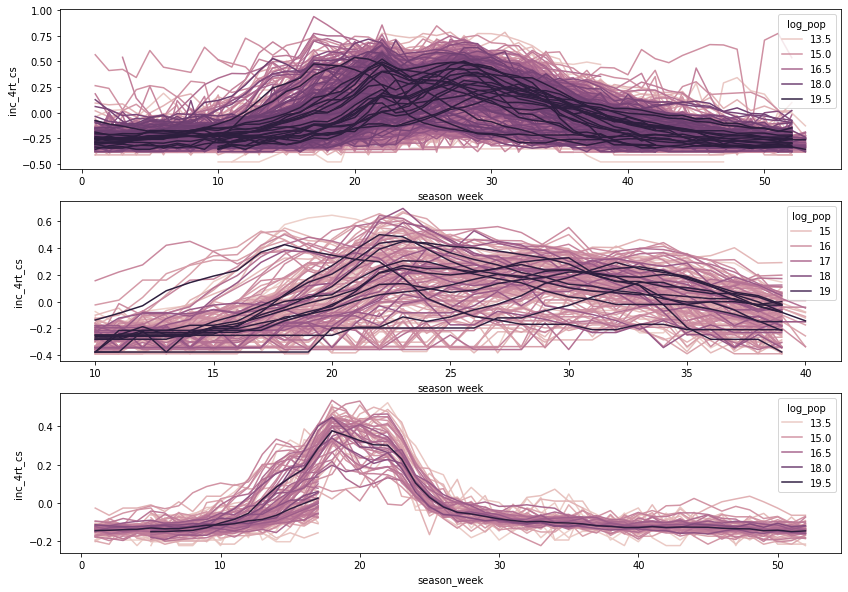

In [7]:
fig, ax = plt.subplots(3, 1)
fig.set_size_inches(14, 10)

ili_to_plot = df.loc[df['source'] == 'ilinet'].assign(season_loc = lambda x: x['season'] + '_' + x['location'])
sns.lineplot(data=ili_to_plot,
             x='season_week',
             y='inc_4rt_cs',
             units='season_loc',
             hue='log_pop',
             estimator=None,
             ci=None,
             ax=ax[0])

flusurv_to_plot = df.loc[df['source'] == 'flusurvnet'].assign(season_loc = lambda x: x['season'] + '_' + x['location'])
sns.lineplot(data=flusurv_to_plot,
             x='season_week',
             y='inc_4rt_cs',
             units='season_loc',
             hue='log_pop',
             estimator=None,
             ci=None,
             ax=ax[1])

hhs_to_plot = df.loc[df['source'] == 'hhs'].assign(season_loc = lambda x: x['season'] + '_' + x['location'])
sns.lineplot(data=hhs_to_plot,
             x='season_week',
             y='inc_4rt_cs',
             units='season_loc',
             hue='log_pop',
             estimator=None,
             ci=None,
             ax=ax[2])


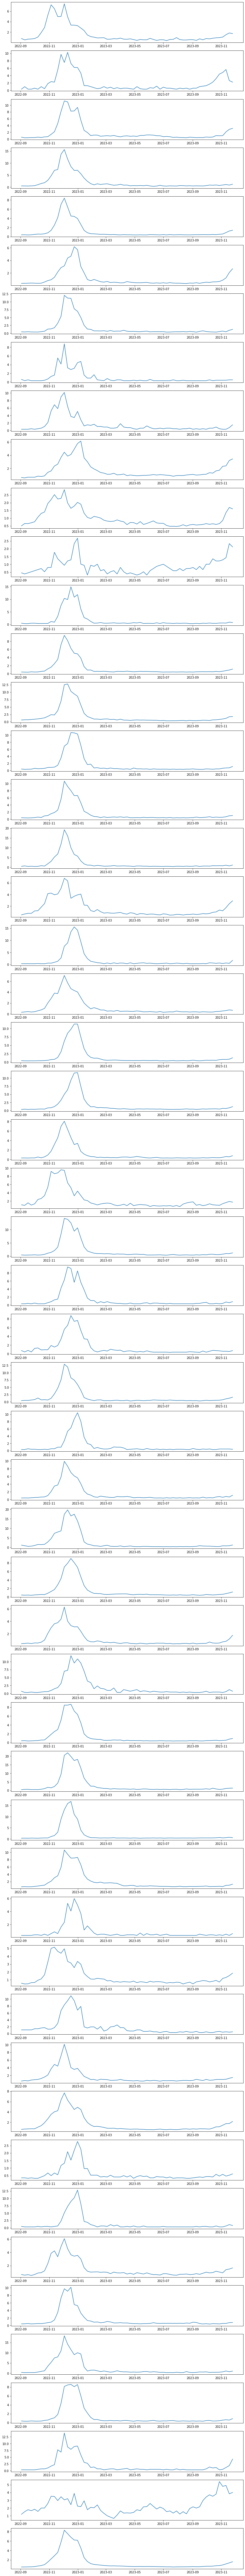

In [8]:
n_loc = len(hhs_to_plot['location'].unique())

fig, ax = plt.subplots(n_loc, 1)
fig.set_size_inches(14, 3*n_loc)

for i, loc in enumerate(hhs_to_plot['location'].unique()):
    loc_dat_hhs = hhs_to_plot.loc[hhs_to_plot['location'] == loc]
    ax[i].plot(loc_dat_hhs['wk_end_date'], loc_dat_hhs['inc'])


# Convert data to format suitable for sarix

In [9]:
# season week relative to christmas
df = df.merge(
    get_holidays() \
      .query("holiday == 'Christmas'") \
      .drop(columns=['holiday', 'date']) \
      .rename(columns={'season_week': 'xmas_week'}),
    how='left',
    on='season') \
  .assign(delta_xmas = lambda x: x['season_week'] - x['xmas_week'])
df['xmas_spike'] = np.maximum(3 - np.abs(df['delta_xmas']), 0)

In [10]:
df_hhs = df.loc[df['source'] == 'hhs']
df_hhs

,agg_level,location,season,season_week,wk_end_date,inc,source,pop,log_pop,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor,xmas_week,delta_xmas,xmas_spike
4959,state,01,2022/23,5.0,2022-09-03,0.769671,hhs,5074296.0,15.439698,0.939675,1.582782,-0.105626,0.695585,22,-17.0,0.0
4960,state,01,2022/23,6.0,2022-09-10,0.513478,hhs,5074296.0,15.439698,0.850598,1.582782,-0.161551,0.695585,22,-16.0,0.0
4961,state,01,2022/23,7.0,2022-09-17,0.651428,hhs,5074296.0,15.439698,0.901822,1.582782,-0.129392,0.695585,22,-15.0,0.0
4962,state,01,2022/23,8.0,2022-09-24,0.690842,hhs,5074296.0,15.439698,0.914966,1.582782,-0.121139,0.695585,22,-14.0,0.0
4963,state,01,2022/23,9.0,2022-10-01,0.769671,hhs,5074296.0,15.439698,0.939675,1.582782,-0.105626,0.695585,22,-13.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8399,national,US,2023/24,13.0,2023-10-28,0.797672,hhs,333287557.0,19.624516,0.948001,1.609735,-0.085707,0.670989,22,-9.0,0.0
8400,national,US,2023/24,14.0,2023-11-04,0.920089,hhs,333287557.0,19.624516,0.982044,1.609735,-0.064689,0.670989,22,-8.0,0.0
8401,national,US,2023/24,15.0,2023-11-11,1.145720,hhs,333287557.0,19.624516,1.036843,1.609735,-0.030857,0.670989,22,-7.0,0.0
8402,national,US,2023/24,16.0,2023-11-18,1.367451,hhs,333287557.0,19.624516,1.083351,1.609735,-0.002144,0.670989,22,-6.0,0.0


In [11]:
batched_xy = df_hhs[["inc_4rt_cs", "xmas_spike"]].values.reshape(len(df_hhs['location'].unique()), -1, 2)
batched_xy

array([[[-1.05626121e-01,  0.00000000e+00],
        [-1.61551493e-01,  0.00000000e+00],
        [-1.29391923e-01,  0.00000000e+00],
        ...,
        [ 2.46951823e-04,  0.00000000e+00],
        [ 3.60183751e-02,  0.00000000e+00],
        [ 2.39962086e-02,  0.00000000e+00]],

       [[-2.22489046e-01,  0.00000000e+00],
        [-7.46972333e-02,  0.00000000e+00],
        [-2.22489046e-01,  0.00000000e+00],
        ...,
        [ 2.49100363e-01,  0.00000000e+00],
        [ 8.93130097e-02,  0.00000000e+00],
        [ 5.78133302e-02,  0.00000000e+00]],

       [[-1.58794933e-01,  0.00000000e+00],
        [-1.99694552e-01,  0.00000000e+00],
        [-1.92090785e-01,  0.00000000e+00],
        ...,
        [ 3.68765995e-02,  0.00000000e+00],
        [ 9.09162300e-02,  0.00000000e+00],
        [ 1.10388414e-01,  0.00000000e+00]],

       ...,

       [[-1.93517678e-01,  0.00000000e+00],
        [-1.93517678e-01,  0.00000000e+00],
        [-1.93517678e-01,  0.00000000e+00],
        ...,
     

In [12]:
batched_xy.shape

(53, 65, 2)

In [13]:
sarix_fit_all_locs_theta_pooled = sarix.SARIX(
    xy = batched_xy,
    p = 8,
    d = 0,
    P = 0,
    D = 0,
    season_period = 1,
    transform='none',
    theta_pooling='shared',
    sigma_pooling='none',
    forecast_horizon = 5,
    num_warmup = 1000,
    num_samples = 1000,
    num_chains = 1)


sample: 100%|██████████| 2000/2000 [00:27<00:00, 71.88it/s, 63 steps of size 6.23e-02. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 sigma[0,0]      0.05      0.00      0.05      0.04      0.05   1383.56      1.00
 sigma[0,1]      0.18      0.02      0.18      0.16      0.21    900.22      1.00
 sigma[1,0]      0.08      0.01      0.08      0.07      0.09   1451.72      1.01
 sigma[1,1]      0.18      0.02      0.18      0.15      0.21   1182.66      1.00
 sigma[2,0]      0.04      0.00      0.04      0.04      0.05   1229.01      1.00
 sigma[2,1]      0.14      0.01      0.14      0.12      0.16    972.39      1.01
 sigma[3,0]      0.04      0.00      0.04      0.04      0.05   1274.36      1.00
 sigma[3,1]      0.15      0.02      0.15      0.13      0.18   2131.94      1.00
 sigma[4,0]      0.03      0.00      0.03      0.03      0.04   1644.36      1.00
 sigma[4,1]      0.14      0.01      0.14      0.12      0.16   1080.97      1.00
 sigma[5,0]      0.04      0.00      0.04      0.03      0.05   2020.36      1.00
 sigma[5,1]    

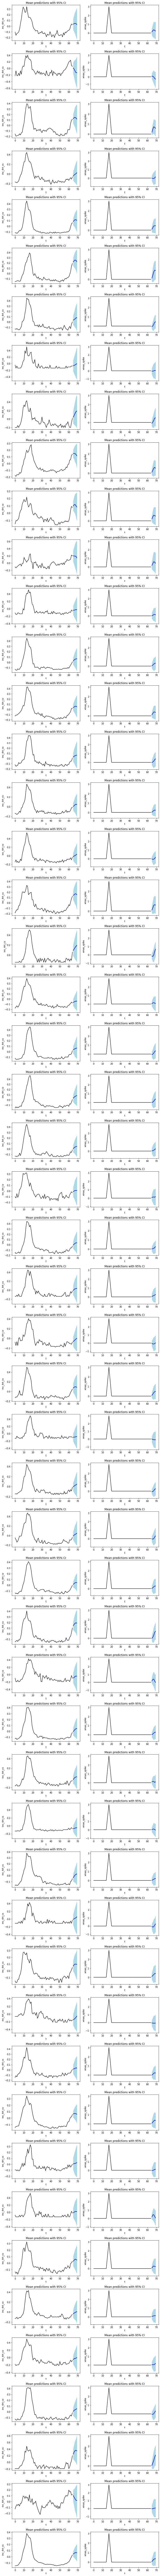

In [14]:
def plot_batched_forecasts(model_fit, var_names):
    L = model_fit.xy_orig.shape[0]
    T_orig = model_fit.xy_orig.shape[-2]
    T = model_fit.xy.shape[-2]
    t_orig = np.arange(T_orig)
    t_transformed = np.arange(T) + T_orig - T
    t_pred = T_orig + np.arange(model_fit.forecast_horizon)
    
    fig, ax = plt.subplots(L, len(var_names), figsize=(10, 3 * L), squeeze=False)
    
    for l in range(L):
        percentile_levels = [2.5, 97.5]
        median_prediction = np.median(model_fit.predictions_modeled_scale[..., l, :, :], axis=0)
        percentiles = np.percentile(model_fit.predictions_modeled_scale[..., l, :, :], percentile_levels, axis=0)
        median_prediction_orig = np.median(model_fit.predictions[..., l, :, :], axis=0)
        percentiles_orig = np.percentile(model_fit.predictions[..., l, :, :], percentile_levels, axis=0)
        
        for (i, var_name) in enumerate(var_names):
            ax[l, 0 + i].fill_between(t_pred, percentiles_orig[0, :, i], percentiles_orig[1, :, i], color='lightblue')
            ax[l, 0 + i].plot(t_pred, median_prediction_orig[:, i], 'blue', ls='solid', lw=2.0)
            ax[l, 0 + i].plot(t_orig, model_fit.xy_orig[l, :, i], 'black', ls='solid')
            ax[l, 0 + i].set(xlabel="t", ylabel=var_name, title="Mean predictions with 95% CI")
            
            # ax[l, 1 + i*2].fill_between(t_pred, percentiles[0, :, i], percentiles[1, :, i], color='lightblue')
            # ax[l, 1 + i*2].plot(t_pred, median_prediction[:, i], 'blue', ls='solid', lw=2.0)
            # ax[l, 1 + i*2].plot(t_transformed, model_fit.xy[l, :, i], 'black', ls='solid')
            # ax[l, 1 + i*2].set(xlabel="t", ylabel=var_name + " (" + model_fit.transform + " scale)", title="Mean predictions with 95% CI")
    
    plt.tight_layout()
    plt.show()

plot_batched_forecasts(sarix_fit_all_locs_theta_pooled, ['inc_4rt_cs', 'xmas_spike'])

In [15]:
pred_qs = np.percentile(sarix_fit_all_locs_theta_pooled.predictions[..., :, :, 0],
                        np.array(q_levels) * 100, axis=0)
pred_qs.shape

(23, 53, 5)

In [16]:
df_hhs_last_obs = df_hhs.groupby(['location']).tail(1)

In [17]:
preds_df = pd.concat([
  pd.DataFrame(pred_qs[i, :, :]) \
    .set_axis(df_hhs_last_obs['location'], axis='index') \
    .set_axis(np.arange(1, max_horizon+1), axis='columns') \
    .assign(output_type_id = q_label) \
    for i, q_label in enumerate(q_labels)]) \
  .reset_index() \
  .melt(['location', 'output_type_id'], var_name='horizon') \
  .merge(df_hhs_last_obs, on='location', how='left')
preds_df

,location,output_type_id,horizon,value,agg_level,season,season_week,wk_end_date,inc,source,pop,log_pop,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor,xmas_week,delta_xmas,xmas_spike
0,01,0.01,1,-0.078415,state,2023/24,17.0,2023-11-25,1.715615,hhs,5074296.0,15.439698,1.146136,1.582782,0.023996,0.695585,22,-5.0,0.0
1,02,0.01,1,-0.178762,state,2023/24,17.0,2023-11-25,2.224847,hhs,733583.0,13.505696,1.222678,1.655418,0.057813,0.676343,22,-5.0,0.0
2,04,0.01,1,0.017453,state,2023/24,17.0,2023-11-25,3.169978,hhs,7359197.0,15.811461,1.335384,1.740941,0.110388,0.652278,22,-5.0,0.0
3,05,0.01,1,-0.146612,state,2023/24,17.0,2023-11-25,1.235754,hhs,3045637.0,14.929221,1.056472,1.828237,-0.061579,0.636299,22,-5.0,0.0
4,06,0.01,1,0.004976,state,2023/24,17.0,2023-11-25,1.392520,hhs,39029342.0,17.479824,1.088246,1.575401,0.060095,0.626322,22,-5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6090,54,0.99,5,0.374330,state,2023/24,17.0,2023-11-25,1.048736,hhs,1775156.0,14.389399,1.014371,1.839540,-0.075656,0.624101,22,-5.0,0.0
6091,55,0.99,5,0.292562,state,2023/24,17.0,2023-11-25,0.893407,hhs,5892539.0,15.589198,0.974924,1.704339,-0.015049,0.583737,22,-5.0,0.0
6092,56,0.99,5,0.835364,state,2023/24,17.0,2023-11-25,4.272504,hhs,581381.0,13.273162,1.438548,1.727251,0.199454,0.628606,22,-5.0,0.0
6093,72,0.99,5,0.342053,state,2023/24,17.0,2023-11-25,4.010006,hhs,3221789.0,14.985447,1.415979,1.470274,0.123182,0.833383,22,-5.0,0.0


In [18]:
# build data frame with predictions on the original scale
preds_df['value'] = (preds_df['value'] + preds_df['inc_4rt_center_factor']) * preds_df['inc_4rt_scale_factor']
preds_df['value'] = (np.maximum(preds_df['value'], 0.0) ** 4 - 0.01 - 0.75**4) * preds_df['pop'] / 100000
preds_df['value'] = np.maximum(preds_df['value'], 0.0)

# keep just required columns and rename to match hub format
preds_df = preds_df[['location', 'wk_end_date', 'horizon', 'output_type_id', 'value']]

preds_df['target_end_date'] = preds_df['wk_end_date'] + pd.to_timedelta(7*preds_df['horizon'], unit='days')
preds_df['reference_date'] = ref_date
preds_df['horizon'] = preds_df['horizon'] - 2
preds_df['output_type'] = 'quantile'
preds_df['target'] = 'wk inc flu hosp'
preds_df.drop(columns='wk_end_date', inplace=True)

preds_df

/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_33399/267905179.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds_df['target_end_date'] = preds_df['wk_end_date'] + pd.to_timedelta(7*preds_df['horizon'], unit='days')
/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_33399/267905179.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds_df['reference_date'] = ref_date
/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_33399/267905179.py:11: SettingWithCopyWarning: 
A va

,location,horizon,output_type_id,value,target_end_date,reference_date,output_type,target
0,01,-1,0.01,29.641175,2023-12-02,2023-12-02,quantile,wk inc flu hosp
1,02,-1,0.01,0.982565,2023-12-02,2023-12-02,quantile,wk inc flu hosp
2,04,-1,0.01,111.988402,2023-12-02,2023-12-02,quantile,wk inc flu hosp
3,05,-1,0.01,9.624034,2023-12-02,2023-12-02,quantile,wk inc flu hosp
4,06,-1,0.01,254.456591,2023-12-02,2023-12-02,quantile,wk inc flu hosp
...,...,...,...,...,...,...,...,...
6090,54,3,0.99,196.202695,2023-12-30,2023-12-02,quantile,wk inc flu hosp
6091,55,3,0.99,273.947894,2023-12-30,2023-12-02,quantile,wk inc flu hosp
6092,56,3,0.99,235.792740,2023-12-30,2023-12-02,quantile,wk inc flu hosp
6093,72,3,0.99,276.883618,2023-12-30,2023-12-02,quantile,wk inc flu hosp


In [19]:
if not Path('../../submissions-hub/model-output/UMass-sarix').exists():
    Path('../../submissions-hub/model-output/UMass-sarix').mkdir(parents=True)

preds_df.to_csv(f'../../submissions-hub/model-output/UMass-sarix/{str(ref_date)}-UMass-sarix.csv', index=False)